In [1]:
from collections import Counter
import math
import os
import time

from torchvision.datasets import CocoCaptions
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import nltk
nltk.download('punkt')
import matplotlib.pyplot as plt
from matplotlib import style

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Erik\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
image_transform = Compose([
    Resize((224, 224)),
    ToTensor(),
    Normalize(mean=[0.485, 0.456, 0.406],
              std=[0.229, 0.224, 0.225])
])

In [3]:
class CaptionPreprocessor:
    def __init__(self, captions, vocab_threshold=5, max_caption_length=20):
        self.max_caption_length = max_caption_length

        all_tokens = [token for caption in captions for token in nltk.tokenize.word_tokenize(caption.lower())]
        counter = Counter(all_tokens)
        self.vocab = {token: idx for idx, (token, count) in enumerate(counter.items()) if count >= vocab_threshold}

        self.vocab['<pad>'] = len(self.vocab)
        self.vocab['<start>'] = len(self.vocab)
        self.vocab['<end>'] = len(self.vocab)
        self.vocab['<unk>'] = len(self.vocab)

        self.idx_to_token = {idx: token for token, idx in self.vocab.items()}

        self.captions_tokenized = self.tokenize_captions(captions)

    def preprocess(self, caption):
        tokens = nltk.tokenize.word_tokenize(caption.lower())
        caption_indices = [self.vocab['<start>']] + [self.vocab.get(token, self.vocab['<unk>']) for token in tokens] + [self.vocab['<end>']]

        if len(caption_indices) < self.max_caption_length:
            caption_indices += [self.vocab['<pad>']] * (self.max_caption_length - len(caption_indices))

        return caption_indices[:self.max_caption_length]

    def tokenize_captions(self, captions):
        return [self.preprocess(caption) for caption in captions]

In [4]:
class CustomCocoDataset(Dataset):
    def __init__(self, coco_dataset, caption_preprocessor):
        self.coco_dataset = coco_dataset
        self.caption_preprocessor = caption_preprocessor

    def __len__(self):
        return len(self.coco_dataset)

    def __getitem__(self, idx):
        img, caption_list = self.coco_dataset[idx]
        caption = caption_list[0]
        preprocessed_caption = torch.tensor(self.caption_preprocessor.preprocess(caption))
        return img, preprocessed_caption

In [5]:
class PatchEmbedding(nn.Module):
    def __init__(self, patch_size, in_channels, embed_dim):
        super().__init__()
        self.proj = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.proj(x)
        x = x.flatten(2).transpose(1, 2)
        return x


class VisionTransformer(nn.Module):
    def __init__(self, in_channels, patch_size, embed_dim, num_layers, num_heads, mlp_dim, num_classes):
        super().__init__()
        self.patch_embed = PatchEmbedding(patch_size, in_channels, embed_dim)
        self.positional_encoding = nn.Parameter(torch.randn(1, (224 // patch_size) * (224 // patch_size) + 1, embed_dim))

        self.transformer_layers = nn.ModuleList([
            nn.TransformerEncoderLayer(embed_dim, num_heads, mlp_dim)
            for _ in range(num_layers)
        ])

        self.classification_head = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        x = self.patch_embed(x)
        x = x + self.positional_encoding[:, :-1]
        for layer in self.transformer_layers:
            x = layer(x)

        return x

In [6]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        self.encoding = nn.Parameter(torch.zeros(1, max_len, d_model), requires_grad=False)

        pos = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-torch.log(torch.tensor(10000.0)) / d_model))
        self.encoding[:, :, 0::2] = torch.sin(pos * div_term)
        self.encoding[:, :, 1::2] = torch.cos(pos * div_term)


class TransformerCaptionDecoder(nn.Module):
    def __init__(self, vocab_size, d_model, num_layers, num_heads, mlp_dim, max_len=128):
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, d_model)
        self.positional_encoding = PositionalEncoding(d_model, max_len)
        self.transformer_layers = nn.ModuleList([
            nn.TransformerDecoderLayer(d_model, num_heads, mlp_dim)
            for _ in range(num_layers)
        ])
        self.output_layer = nn.Linear(d_model, vocab_size)

    def forward(self, captions, memory):
        captions = self.embedding(captions) + self.positional_encoding.encoding[:, :captions.shape[1]]

        for layer in self.transformer_layers:
            captions = layer(captions, memory)

        logits = self.output_layer(captions)
        return logits

In [7]:
class ImageCaptioningModel(nn.Module):
    def __init__(self, image_encoder, caption_decoder, embedding_size, start_token_index):
        super(ImageCaptioningModel, self).__init__()
        self.image_encoder = image_encoder
        self.caption_decoder = caption_decoder
        self.embedding_size = embedding_size
        self.start_token_index = start_token_index

    def forward(self, images, captions):
        image_features = self.image_encoder(images)
        num_patches = (224 // 16) * (224 // 16)
        image_features_flattened = image_features.permute(1, 0, 2).reshape(-1, num_patches, self.embedding_size)

        # print("Start token index:", caption_preprocessor.vocab['<start>'])

        start_token_embeddings = self.caption_decoder.embedding(torch.tensor([self.start_token_index], device=images.device)).repeat(image_features.shape[0], 1, 1) # Get the <start> token embedding and repeat it for the batch size
        image_features_summed = image_features_flattened.sum(dim=1).unsqueeze(1)
        memory = torch.cat([start_token_embeddings, image_features_summed], dim=1) # Concatenate the start token embeddings with the flattened image features

        memory = memory.transpose(0, 1)

        captions = captions.transpose(0, 1)

        output = self.caption_decoder(captions, memory)

        output = output.transpose(0, 1)

        return output

In [8]:
class NoamScheduler:
    def __init__(self, optimizer, d_model, warmup_steps=4000):
        self.optimizer = optimizer
        self.d_model = d_model
        self.warmup_steps = warmup_steps
        self.current_step = 0

    def step(self):
        self.current_step += 1
        lr = self.learning_rate()
        for param_group in self.optimizer.param_groups:
            if param_group['lr'] != lr:
                print(f"Learning rate changed: {param_group['lr']} -> {lr}")
            param_group['lr'] = lr

    def learning_rate(self):
        arg1 = self.current_step ** -0.5
        arg2 = min(self.current_step * self.warmup_steps ** -1.5, 1)
        return (self.d_model ** -0.5) * min(arg1, arg2)

In [9]:
def plot_and_save(train_losses, val_losses, learning_rates, max_min_loss_diffs):
    plt.style.use('classic')

    fig, ax = plt.subplots(figsize=(15, 6))
    ax.plot(train_losses, label='Train Loss')
    ax.plot(val_losses, label='Validation Loss')
    ax.set_xlabel('Epochs', fontsize=14)
    ax.set_ylabel('Loss', fontsize=14)
    ax.set_title('Training and Validation Losses', fontsize=16)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.grid()
    ax.legend(fontsize=12)
    fig.savefig('losses.png')

    fig, ax = plt.subplots(figsize=(15, 6))
    ax.plot(learning_rates, label='Learning Rate')
    ax.set_xlabel('Epochs', fontsize=14)
    ax.set_ylabel('Learning Rate', fontsize=14)
    ax.set_title('Learning Rate Schedule', fontsize=16)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.grid()
    ax.legend(fontsize=12)
    fig.savefig('learning_rates.png')

    fig_ax = plt.subplots(figsize=15, 6)
    ax.plot(max_min_loss_diffs, label='Loss Difference')
    ax.set_xlabel('Epochs', fontsize=14)
    ax.set_ylabel('Loss Difference', fontsize=14)
    ax.set_title('Difference Between Max and Min Loss per Epoch', fontsize=16)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.grid()
    ax.legend(fontsize=12)
    fig.savefig('loss_differences.png')


In [10]:
train_dataset = CocoCaptions(root='./coco/images',
                       annFile='./coco/annotations/captions_train2014.json',
                       transform=image_transform)
val_dataset = CocoCaptions(root='./coco/images',
                           annFile='./coco/annotations/captions_val2014.json',
                           transform=image_transform)
train_captions = [entry['caption'] for entry in train_dataset.coco.anns.values()]
val_captions = [entry['caption'] for entry in val_dataset.coco.anns.values()]

max_caption_length_train = max([len(nltk.tokenize.word_tokenize(caption.lower())) for caption in train_captions])
max_caption_length_val = max([len(nltk.tokenize.word_tokenize(caption.lower())) for caption in val_captions])
max_caption_length = max(max_caption_length_train, max_caption_length_val)
print('Maximum caption length (without <start>, <end>, and <pad> tokens):', max_caption_length)

caption_preprocessor = CaptionPreprocessor(train_captions + val_captions)
custom_train_dataset = CustomCocoDataset(train_dataset, caption_preprocessor)
custom_val_dataset = CustomCocoDataset(val_dataset, caption_preprocessor)

batch_size = 192
train_data_loader = DataLoader(custom_train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_data_loader = DataLoader(custom_val_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

loading annotations into memory...
Done (t=0.76s)
creating index...
index created!
loading annotations into memory...
Done (t=0.42s)
creating index...
index created!
Maximum caption length (without <start>, <end>, and <pad> tokens): 57


['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


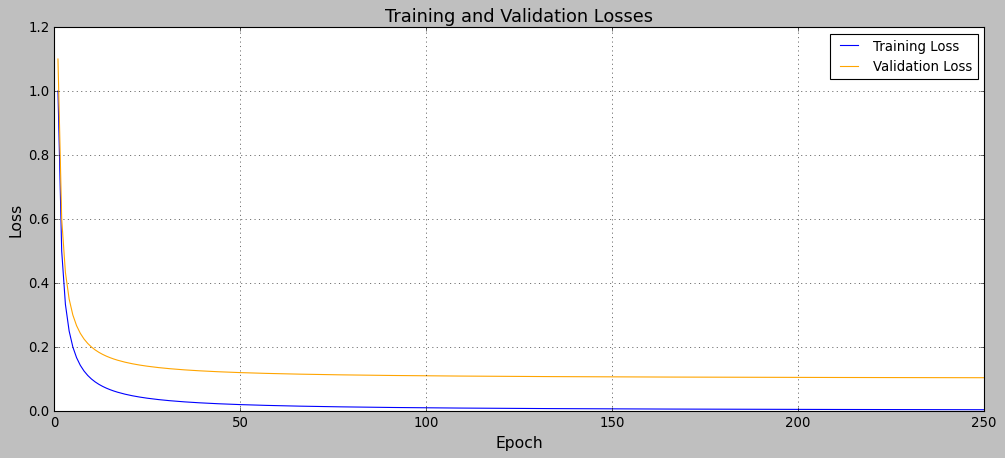

In [13]:
# print(plt.style.available)
#
# plt.style.use('classic')
# # Some example data
# epochs = list(range(1, 251))
# train_losses = [1 / epoch for epoch in epochs]
# val_losses = [(1 / epoch) + 0.1 for epoch in epochs]
#
# # Create the figure and axes with a specified figure size
# fig, ax = plt.subplots(figsize=(15, 6))
#
# # Plot the training and validation losses
# ax.plot(epochs, train_losses, label='Training Loss', color='blue')
# ax.plot(epochs, val_losses, label='Validation Loss', color='orange')
#
# # Set labels and title
# ax.set_xlabel('Epoch', fontsize=14)
# ax.set_ylabel('Loss', fontsize=14)
# ax.set_title('Training and Validation Losses', fontsize=16)
#
# # Increase the size of the tick labels
# ax.tick_params(axis='both', which='major', labelsize=12)
#
# # Add a grid for better readability
# ax.grid()
#
# # Add a legend
# ax.legend(fontsize=12)
#
# # Save the figure
# fig.savefig('losses_plot.png')
#
# # Display the plot
# plt.show()

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

image_encoder = VisionTransformer(in_channels=3,
                                  patch_size=16,
                                  embed_dim=768,
                                  num_layers=12,
                                  num_heads=12,
                                  mlp_dim=3072,
                                  num_classes=768).to(device)
max_caption_index = max([max(caption) for caption in caption_preprocessor.captions_tokenized])
caption_decoder = TransformerCaptionDecoder(vocab_size=max_caption_index + 1,
                                            d_model=768,
                                            num_layers=6,
                                            num_heads=8,
                                            mlp_dim=2048).to(device)
embedding_size = 768
model = ImageCaptioningModel(image_encoder, caption_decoder, embedding_size, caption_preprocessor.vocab['<start>']).to(device)

if torch.cuda.device_count() > 1:
    print(f'Using {torch.cuda.device_count()} GPUs')
    model = nn.DataParallel(model)

criterion = nn.CrossEntropyLoss(ignore_index=caption_preprocessor.vocab['<pad>'])
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=True)
scheduler = NoamScheduler(optimizer, d_model=768, warmup_steps=4000)

num_epochs = 20
best_val_loss = float('inf')

train_losses = []
val_losses = []
learning_rates = []
max_min_loss_diffs = []
save_name = ''

print('**********STARTING TRAINING**********')
training_start = time.time()
for epoch in range(num_epochs):
    epoch_start = time.time()

    epoch_max_loss = float('-inf')
    epoch_min_loss = float('inf')

    model.train()
    train_loss = 0
    total_samples = len(train_data_loader.dataset)
    batch_size = train_data_loader.batch_size
    max_iterations = math.ceil(total_samples / batch_size)
    print(f'Total samples: {total_samples}, Batch size: {batch_size}, Maximum iterations: {max_iterations}')

    epoch_train_start = time.time()
    for i, (images, captions) in enumerate(train_data_loader):
        images = images.to(device)
        captions_input = captions[:, :-1].to(device)
        captions_target = captions[:, 1:].to(device)

        optimizer.zero_grad()
        output = model(images, captions_input)

        loss = criterion(output.reshape(-1, 28796), captions_target.view(-1))
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        if train_loss > epoch_max_loss:
            epoch_max_loss = train_loss
            print(f'Max loss set to: {epoch_max_loss}')
        if train_loss < epoch_min_loss:
            epoch_min_loss = train_loss
            print(f'Min loss set to: {epoch_min_loss}')

        if i % 20 == 0:
            print(f'Epoch: {epoch+1}/{num_epochs}, Iteration: {i}, Loss: {loss.item()}')

    epoch_train_end = time.time()
    epoch_train_time = epoch_train_end - epoch_train_start
    print(f'Epoch {epoch+1} training time: {epoch_train_time}')

    epoch_max_min_diff = epoch_max_loss - epoch_min_loss
    max_min_loss_diffs.append(epoch_max_min_diff)
    print(f'Difference between max and min loss in epoch {epoch+1}: {epoch_max_min_diff}')

    train_loss /= len(train_data_loader)

    model.eval()
    val_loss = 0

    epoch_val_start = time.time()
    with torch.no_grad():
        for images, captions in val_data_loader:
            images = images.to(device)
            captions_input = captions[:, :-1].to(device)
            captions_target = captions[:, 1:].to(device)

            output = model(images, captions_input)
            loss = criterion(output.reshape(-1, 28796), captions_target.view(-1))

            val_loss += loss.item()

    epoch_val_end = time.time()
    epoch_val_time = epoch_val_end - epoch_val_start
    print(f'Epoch {epoch+1} validation time: {epoch_val_time}')

    epoch_end = time.time()
    epoch_time = epoch_end - epoch_start
    print(f'Epoch {epoch+1} total time: {epoch_time}')

    val_loss /= len(val_data_loader)
    print(f'Epoch: {epoch+1}/{num_epochs}, Train Loss: {train_loss}, Val Loss: {val_loss}')
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    learning_rates.append(optimizer.param_groups[0]['lr'])

    if val_loss < best_val_loss:
        best_val_loss = val_loss

        if os.path.exists(save_name):
            os.remove(save_name)

        save_name = f'best_loss_model_{epoch}.pth'
        torch.save(model.state_dict(), save_name)

    scheduler.step()

training_end = time.time()
training_time = training_end - training_start
print(f'Total training time: {training_time}')

plot_and_save(train_losses, val_losses, learning_rates, max_min_loss_diffs)